<a href="https://colab.research.google.com/github/oakfr/nn-training/blob/main/build_makemore_mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving names.txt to names.txt


In [3]:
# read the data
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3

def build_dataset(words):
  # build dataset
  X = []
  Y = []

  for w in words:
    context = [0] * block_size
    for c in w + '.':
      ix = stoi[c]
      Y.append(ix)
      X.append(context)
      #print(''.join([itos[i] for i in context]), ' --> ', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [24]:
# first training code

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden),  generator=g) * 5/3 / ((n_embd * block_size ** 0.5))
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))
bngain = torch.randn(n_hidden)
bnbias = torch.zeros(n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

In [25]:
for p in parameters:
  p.requires_grad = True

In [26]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad 

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000: 3.3106
  10000/ 200000: 2.1391
  20000/ 200000: 2.2659
  30000/ 200000: 2.3744
  40000/ 200000: 1.9450
  50000/ 200000: 2.5670
  60000/ 200000: 2.3553
  70000/ 200000: 2.0470
  80000/ 200000: 2.4084
  90000/ 200000: 2.0140
 100000/ 200000: 1.8763
 110000/ 200000: 2.2306
 120000/ 200000: 2.0185
 130000/ 200000: 2.4578
 140000/ 200000: 2.4177
 150000/ 200000: 2.3040
 160000/ 200000: 2.1655
 170000/ 200000: 1.8201
 180000/ 200000: 2.2097
 190000/ 200000: 1.8222
2.3067684173583984


In [32]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  return loss
  
print('train loss = ' + str(split_loss('train').item()))
print('dev   loss = ' + str(split_loss('dev').item()))

train loss = 2.0980818271636963
dev   loss = 2.1265649795532227


# after batch norm
train loss = 2.0972
dev loss = 2.1304

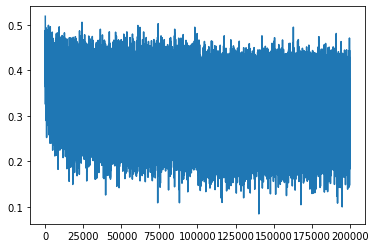

In [12]:
plt.plot(lossi)

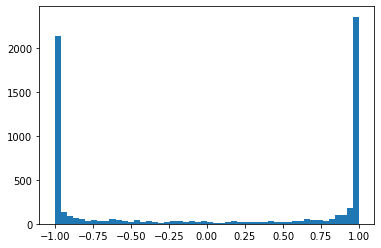

In [ ]:
plt.hist(h.view(-1).tolist(),50);

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  context = [0] * block_size

  out = []

  while True:

    emb = C[torch.tensor(context)]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
    
  word = ''.join([itos[i] for i in out])
  print(word)



carmahzati.
hella.
jalixalety.
halaysa.
jazonen.
delyah.
jaleni.
nelania.
chaiiv.
elle.
gyd.
lio.
din.
quinn.
sulinea.
jamilairaero.
dearisi.
jameendredy.
emmedi.
abetteferia.


In [7]:
class Linear:

  def __init__ (self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g)# / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__ (self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [8]:
class BatchNorm1d:

  def __init__ (self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # running stats
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__ (self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = xhat * self.gamma + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1.0 - self.momentum) * self.running_mean * self.momentum * xmean
        self.running_var = (1.0 - self.momentum) * self.running_var * self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [9]:
class Tanh:

  def __call__ (self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


In [10]:
# build the network
g = torch.Generator().manual_seed(2147483647)
n_embd = 10
n_hidden = 100

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # gain for other layers
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # print number of parameters in total
for p in parameters:
  p.requires_grad = True


47551


In [ ]:
# main training code

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the chars into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)
  
  # backward pass
  for layer in layers:
    #layer.out.retain_grad() # TODO: take out
    for p in layer.parameters():
      p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad 

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 10000:
  #  break

      0/ 200000: 3.2870


In [ ]:
plt.plot(lossi)

layer 2 (      Tanh): mean +0.03, std 0.63, saturated: 1.97%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.53%
layer 8 (      Tanh): mean -0.01, std 0.63, saturated: 2.62%
layer 11 (      Tanh): mean +0.01, std 0.63, saturated: 1.97%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 1.66%


Text(0.5, 1.0, 'activation distribution')

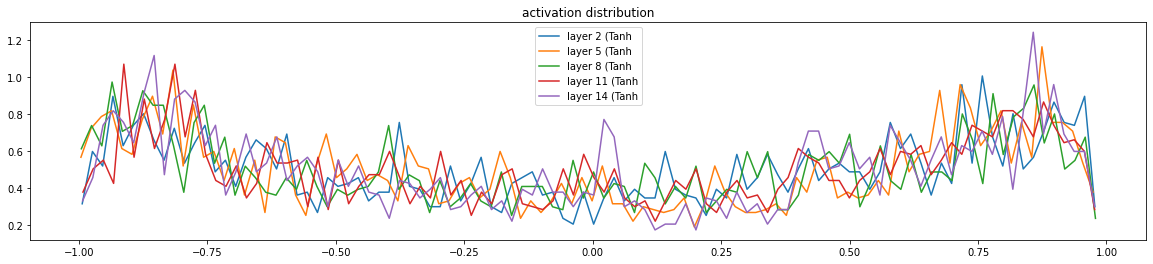

In [36]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [37]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

<ipython-input-37-0f3eb5be538e>:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  t = layer.out.grad


AttributeError: ignored

<Figure size 1440x288 with 0 Axes>

weight   (27, 10) | mean +0.000000 | std 1.093249e-01 | grad:data ratio 1.061023e-03
weight  (30, 100) | mean +0.000072 | std 3.718482e-03 | grad:data ratio 3.625912e-03
weight (100, 100) | mean -0.000019 | std 1.774410e-03 | grad:data ratio 1.779990e-03
weight (100, 100) | mean +0.000002 | std 1.651103e-03 | grad:data ratio 1.638944e-03
weight (100, 100) | mean +0.000003 | std 1.463861e-03 | grad:data ratio 1.459209e-03
weight (100, 100) | mean -0.000025 | std 1.454524e-03 | grad:data ratio 1.448511e-03
weight  (100, 27) | mean +0.000017 | std 2.689422e-03 | grad:data ratio 2.719398e-03


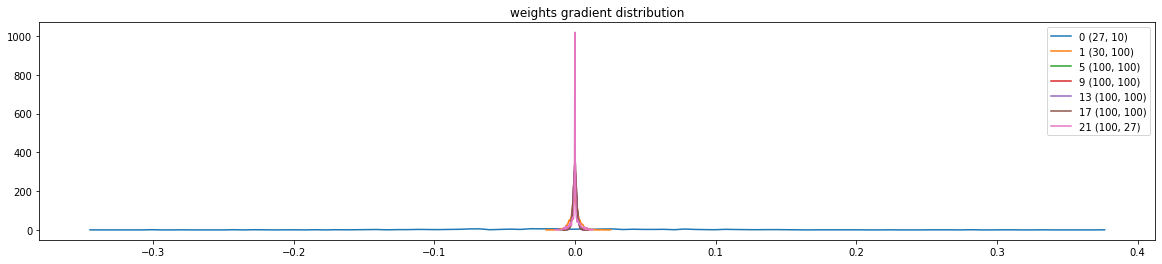

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

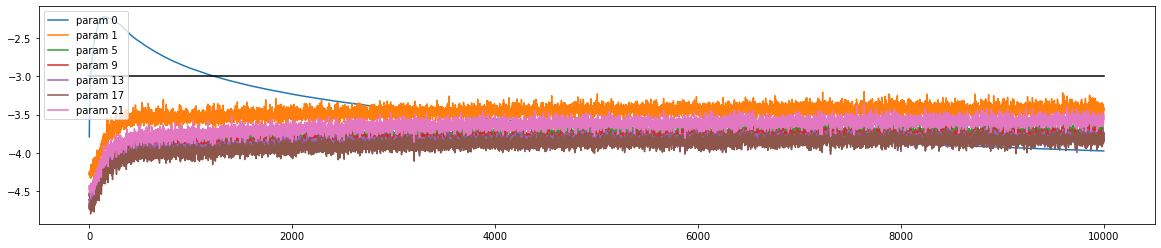

In [39]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [40]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.87640118598938
val 2.875351667404175


In [44]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(1):

  context = [0] * block_size
  out = []

  while True:

    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0], -1)
    for i,layer in enumerate(layers):
     # print(i,x)
      x = layer(x)
    logits = x
    probs = F.softmax(logits, dim=1)
    #print(logits)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    out.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break

  print(''.join([itos[i] for i in out]))

carmahxaae.
